In [1]:
import pandas as pd
from os.path import join, isdir, exists, basename, dirname
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle

In [2]:
# don_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/"
# #samples = "preB,postB"

# ## Parameters:
# # af thresholds
# # coverage threshold
# # other_af thresholds
# # number of cells / fraction cells
# # number of other cells / fraction other cells

# ### Smaller params
# af_ts = [0.01, 0.1, 0.4, 0.8,]
# oth_af_ts = [0.01, 0.1, 0.4]
# cov_ts = [2, 10, 30] # mean coverage at position for cells with the AF
# oth_cov_ts = [2, 10, 30]  # mean coverage for cells without AF 
# num_cells = [5, 10, 30] # num cells and fraction are for cells with sufficient coverage
# oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage
# mean_pos_cov = [0, 10] #populatiion average coverage at that position

# use_small = False
# to_plots = True




# af_ts = [0.01, 0.1, 0.4, 0.8, 0.95]
# oth_af_ts = [0.01, 0.1, 0.4, 0.8, 0.95]
# cov_ts = [2, 5, 10, 30] # mean coverage at position for cells with the AF
# oth_cov_ts = [2, 5, 10, 30]  # mean coverage for cells without AF 
# num_cells = [5, 10, 0.1, 0.2, 0.5 ] # num cells and fraction are for cells with sufficient coverage
# oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage
# mean_pos_cov = [0, 2, 5, 10] #populatiion average coverage at that position


In [3]:
try:
    use_small = snakemake.params.get("use_small", False)
    to_plots = snakemake.params.get("to_plots", True)
    don_dir = snakemake.input["don_dir"]
    outdir = snakemake.params["outdir"]

    params = snakemake.config["mt_as_clones"]["params"]
    af_ts = params["af_ts"]
    oth_af_ts = params["oth_af_ts"]
    cov_ts = params["cov_ts"]
    oth_cov_ts = params["oth_cov_ts"]
    num_cells = params["num_cells"]
    oth_num_cells = params["oth_num_cells"]
    mean_pos_cov = params["mean_pos_cov"]
except NameError:
    use_small = False
    to_plots = True
    don_dir = ["/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor0/",
               "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor1/"]
    outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/scrap"
    
    af_ts = [0.01, 0.1, 0.4, 0.8, 0.95]
    oth_af_ts = [0.01, 0.1, 0.4, 0.8, 0.95]
    cov_ts = [2, 5, 10, 30] # mean coverage at position for cells with the AF
    oth_cov_ts = [2, 5, 10, 30]  # mean coverage for cells without AF 
    num_cells = [5, 10, 0.1, 0.2, 0.5 ] # num cells and fraction are for cells with sufficient coverage
    oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage
    mean_pos_cov = [0, 2, 5, 10] #populatiion average coverage at that position

In [4]:
objectives = ["n_vars_obs" , "n_cells_obs"] 
weights = [1,1]
param_objectives = ["cov", "oth_cov", "af", "oth_af", "ncells", "oth_ncells"]
param_weights = [1,1,1,-1,1,1 ]
dendro_objectives = ["obj_nclones_more_than_one_unique", 
                     "variants_with_clone_norm_by_1_over_nclones_with_variant", 
                     "n_clones"]
dendro_weights = [1,1, 1]

all_objectives = objectives+param_objectives+dendro_objectives
all_weights = weights+param_weights+dendro_weights

all_objectives = objectives+param_objectives
all_weights = weights+param_weights

all_weights

[1, 1, 1, 1, 1, -1, 1, 1]

In [5]:
# There are 7 params to use for calling the clone
params = {"af":af_ts,
          "oth_af":oth_af_ts,
          "ncells": num_cells,
          "oth_ncells":oth_num_cells,
          "mean_cov": mean_pos_cov,
          "cov":cov_ts,
          "oth_cov":oth_cov_ts,
         }
param_names = params.keys()
full_params = list(product(*list(params.values())))
full_params = pd.DataFrame(full_params, columns=params.keys())
print(full_params.shape)
full_params.head()

(24000, 7)


,af,oth_af,ncells,oth_ncells,mean_cov,cov,oth_cov
0,0.01,0.01,5.0,0.25,0,2,2
1,0.01,0.01,5.0,0.25,0,2,5
2,0.01,0.01,5.0,0.25,0,2,10
3,0.01,0.01,5.0,0.25,0,2,30
4,0.01,0.01,5.0,0.25,0,5,2


In [6]:
# cells_dir = join(outdir, "cells")
# if not exists(cells_dir):
#     os.mkdir(cells_dir)

In [7]:
#samples = samples.split(",")

In [8]:
#don_dirs = [d for d in glob(don_dir + "/donor*") if isdir(d)]
don_dirs = {int(basename(dirname(x)).split("donor")[-1]):dirname(x) for x in don_dir} #donor{d}/af.tsv

don_dirs

{0: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor0',
 1: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor1'}

In [9]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
    ic(cells_meta.shape)
    cells_meta = cells_meta.loc[af.index]
    ic("After filtering on af indices", cells_meta.shape)
    
    variants = set(af.columns)
    return af, cov, cells_meta, variants



## Informative variants function
#af	oth_af	ncells	oth_ncells	mean_cov	cov	oth_cov
def get_vars(thresholds, position_af, position_cov, return_cells=True):
    """ Sees if current position is an 'informative' variant using current thresholds
    """
    # preprocess ncells thresholds
    if thresholds["ncells"] < 1: #fraction of cells or total
        ncells = int(np.floor(thresholds["ncells"] * len(position_af)))
    else:
        ncells = thresholds["ncells"]
        
    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > thresholds["af"]) & (position_cov > thresholds["cov"])
    in_cells = bin_position_af_cov[bin_position_af_cov].index
    
    #print('bin_pos', bin_position_af_cov)
    #print(bin_position_af_cov.sum())
    
    if thresholds["oth_ncells"] < 1: # Fraction of the remaining population
        oth_ncells = int(np.floor(thresholds["oth_ncells"] * len(position_af)-len(in_cells)))
    else:
        oth_ncells = thresholds["oth_ncells"]    

    # positions that pass the coverage threshold but not the AF threshold. 
    # These are cells confidently not with variant, and oth_ncells needed to pass threshold.
    oth_bin_position_af_cov = (position_af <= thresholds["oth_af"]) & (position_cov > thresholds["oth_cov"])
    oth_bin_position_af_cov = oth_bin_position_af_cov.loc[~(oth_bin_position_af_cov.index.isin(in_cells))]
    
    if (bin_position_af_cov.sum() > ncells) & (oth_bin_position_af_cov.sum() > oth_ncells):
        if return_cells:
            return True, in_cells
        return True
    if return_cells:
        return False, []
    return False

def run_per_pos(af_cov, thresholds ,cov_id="COV-"):
    split = int(af_cov.shape[0]/2)
    af = af_cov.iloc[:split]
    cov = af_cov.iloc[split:]

    cov.index = [x.split(cov_id,1)[1] for x in cov.index]
    thresholds['isVar'] = thresholds.apply(get_vars, args=(af, cov), axis=1)
    thresholds["var"] = af_cov.name
    return thresholds


## Plot 
def plots(params_results, outdir, prefix):
    sns.histplot(params_results["n_vars"])

    cov_groups = params_results.groupby(["cov", "oth_cov", "mean_cov"])

    for ind, val in cov_groups:
        print(ind)
        sns.catplot(data=val, y="n_vars", x= "ncells", 
                    hue="af", row="oth_af", col="oth_ncells", kind="bar")
        plt.suptitle(f"{prefix} cov {ind[0]} oth_cov {ind[1]} mean_cov {ind[2]}")
        plt.tight_layout()
        plt.savefig(join(outdir,f"{prefix}_nvars_thresholds.cov_{ind[0]}_othcov_{ind[1]}_mean_{ind[2]}.png"))
    return

In [10]:
def get_cells(af, cov, oth_af, oth_cov, position_af, position_cov):
    """ Gets cells and oth_cells that pass thresholds. Assumes position already passed.
    """
    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > af) & (position_cov > cov)
    in_cells = bin_position_af_cov[bin_position_af_cov].index
    # positions that pass the coverage threshold but not the AF threshold. 
    # These are cells confidently not with variant, and oth_ncells needed to pass threshold.
    oth_bin_position_af_cov = (position_af <= oth_af) & (position_cov > oth_cov)
    # drop the cells
    oth_bin_position_af_cov = oth_bin_position_af_cov.loc[~(oth_bin_position_af_cov.index.isin(in_cells))]
    oth_cells = oth_bin_position_af_cov[oth_bin_position_af_cov].index
    return {"clone_cells": in_cells, "other_cells": oth_cells}

In [11]:
from src.clone_variants_optim import _objectives_dendro

from src.utils.dendro_clust import run_dynamic

from icecream import ic

In [12]:
def create_dendro(df):
    clusters, link = run_dynamic(df, "jaccard")
    ic(clusters.head())
    return df.groupby("labels").sum(), clusters

def calc_objectives(df):
    return {"n_cells_obs": df.shape[0], "n_vars_obs": df.shape[1]}

def calc_param_objectives(val, params_objectives_l):
    obj_params = {}
    for p in params_objectives_l:
        obj_params[p] = val[p]
    return obj_params

def get_binary_df(val, curr_af, curr_cov):
    curr_df = pd.DataFrame(np.zeros(curr_af.shape), index=curr_af.index, columns=curr_af.columns).astype(bool)
    thresh = [val["af"], val["oth_af"], val["cov"], val["oth_cov"]]
    #c_vars_df = pd.DataFrame(index=curr_af.o)
    for c_var in curr_af.columns:
        #print('c_val', c_var)
        pos_af = curr_af[c_var]
        pos_cov = curr_cov[c_var]
        isVar, cells = get_vars(val, pos_af, pos_cov, return_cells=True)
        if isVar:
            curr_df.loc[cells, c_var] = True
    # create binarized mt-cell df and calculate the dendro objectives 
    print('before remove 0 filter', curr_df.shape)

    curr_df = curr_df.loc[~((curr_df==0).all(axis=1)), ~((curr_df==0).all(axis=0))]
    print('after', curr_df.shape)
    #params_results.loc[ind,"Variants"] = ";".join(curr_vars)
    return curr_df


def evaluate_series(val, curr_af, curr_cov, return_data=True):
    curr_df = get_binary_df(val, curr_af, curr_cov)
    ic(curr_df.shape)
    ic(curr_df.head())
    obj_bin = calc_objectives(curr_df)
    ic(obj_bin)
    obj_params = calc_param_objectives(val, param_objectives)
    ic(obj_params)
    obj = {}
    for i in [obj_bin, obj_params]:
        for o in i:
            obj[o] = i[o]
    if return_data:
        return {"objectives":obj, "binary_df": curr_df}
    return pd.Series(obj)

# def evaluate_series(val, curr_af, curr_cov, return_data=True):
#     curr_df = get_binary_df(val, curr_af, curr_cov)
#     ic(curr_df.shape)
#     dendro_wide, dendro_clusters = create_dendro(curr_df)
#     dendro_wide.index.name = "clone"
#     obj_bin = calc_objectives(dendro_wide)
#     ic(obj_bin)
#     ic(dendro_wide.head())
#     dendro_long = dendro_wide.reset_index().melt(id_vars="clone", var_name="variant",value_name="n_cells")
#     ic(dendro_long.shape)
#     obj_dendro = _objectives_dendro(dendro_long, objectives=dendro_objectives)
#     ic(obj_dendro)
#     obj_params = calc_param_objectives(val, param_objectives)
#     ic(obj_params)
#     obj = {}
#     for i in [obj_bin, obj_dendro, obj_params]:
#         for o in i:
#             obj[o] = i[o]
#     if return_data:
#         return {"objectives":obj, "binary_df": curr_df, "dendro_long":dendro_long,"dendro_cluster": dendro_clusters}
#     return obj
    





### slightly different approach:
1. for each parameter run evaluate_series
2. Create a df of mt-by-cells all as 0. 
3. Loop through each variant and run get_vars_and_cells . This takes one variant, the af and cov of that variant, and returns a dictionary of {v:[cells]}, where cells have the variant with right af and coverage 
4. The dictionary is used to fill in the binary df
5. After loop, remove cells and variants with all 0. 
6. create objective score df with weights and 0 as scores
6. Calculate nvars, ncells by the shape and add to objective
7. objectives_params: adds params objectives to the df
8. cluster with jaccard (issue for many 0's?) and run dynamic tree
9. run dendro_objectives, which uses many of the ones from the clone-vars-table.
10. Return the objectives_params, and the df (with the labels meta) if return_date=True.


In [13]:
for d in don_dirs: 
    print('d', d)
    curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)

    if use_small: 
        curr_af_cov = pd.concat([curr_af.iloc[:100,:100], curr_cov_name.iloc[:100,:100]], verify_integrity=True, sort=False)
        full_params_df = full_params.iloc[:100]
    else:
        full_params_df = full_params.copy()
    #curr_af_cov.apply(run_per_pos, args=(full_params_df,),expand=True)
    all_passed_vars = defaultdict(list)
    params_results = full_params_df.copy()
    params_results["Variants"] = None

d 0
d 1


In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
val = full_params_df.sample(1).iloc[0]
val
out_param_run = evaluate_series(val, curr_af, curr_cov, return_data=True)
out_param_run

before remove 0 filter (5691, 195)
after (5691, 35)


{'objectives': {'n_cells_obs': 5691,
  'n_vars_obs': 35,
  'cov': 5.0,
  'oth_cov': 2.0,
  'af': 0.95,
  'oth_af': 0.01,
  'ncells': 0.5,
  'oth_ncells': 0.8},
 'binary_df':                           4917G  1438G  16296T  16519C    73G  5147A  4769G  \
 Cell                                                                          
 AAACGAAAGGAGACTC-1_Flt3l   True  False    True    True  False   True   True   
 AAACGAAAGTCACGCC-1_Flt3l   True   True    True    True   True   True   True   
 AAACGAACAAGACTAA-1_Flt3l   True   True   False   False   True   True   True   
 AAACGAACACAGTAGG-1_Flt3l   True   True   False    True   True  False   True   
 AAACGAACATGTAGAA-1_Flt3l   True   True   False    True   True   True   True   
 ...                         ...    ...     ...     ...    ...    ...    ...   
 TTTGTGTCAATGACTC-1_Input   True   True   False    True   True   True   True   
 TTTGTGTCAGAAAGAG-1_Input   True   True    True    True   True   True   True   
 TTTGTGTCATAGCCAT-1_Input  

In [16]:
#pd.DataFrame(results_df)

before remove 0 filter (5691, 195)
after (5691, 39)
before remove 0 filter (5691, 195)
after (5691, 36)
before remove 0 filter (5691, 195)
after (5664, 15)
before remove 0 filter (5691, 195)
after (5682, 30)
before remove 0 filter (5691, 195)
after (5691, 38)
before remove 0 filter (5691, 195)
after (4287, 37)
before remove 0 filter (5691, 195)
after (4299, 28)
before remove 0 filter (5691, 195)
after (4339, 39)
before remove 0 filter (5691, 195)
after (3428, 1)
before remove 0 filter (5691, 195)
after (5691, 38)


In [18]:
results_df.head()

,n_cells_obs,n_vars_obs,cov,oth_cov,af,oth_af,ncells,oth_ncells
10647,5691.0,39.0,5.0,30.0,0.40,0.10,5.0,0.6
21860,5691.0,36.0,5.0,2.0,0.95,0.40,0.2,0.8
21835,5664.0,15.0,10.0,30.0,0.95,0.40,0.2,0.8
7241,5682.0,30.0,10.0,5.0,0.10,0.40,0.1,0.8
4674,5691.0,38.0,2.0,10.0,0.01,0.95,0.5,0.6


In [19]:
all_objectives

['n_vars_obs',
 'n_cells_obs',
 'cov',
 'oth_cov',
 'af',
 'oth_af',
 'ncells',
 'oth_ncells']

In [20]:
all_weights

[1, 1, 1, 1, 1, -1, 1, 1]

In [22]:
import src.clone_variants_optim as optim

n_cells_obs    True
n_vars_obs     True
cov            True
oth_cov        True
af             True
oth_af         True
ncells         True
oth_ncells     True
dtype: bool
(10, 8)
objs_total n_cells_obs    50463.00
n_vars_obs       301.00
cov              157.00
oth_cov          123.00
af                 5.12
dtype: float64


In [24]:
results_norm

,n_cells_obs,n_vars_obs,cov,oth_cov,af,oth_af,ncells,oth_ncells,multi
10647,0.112776,0.129568,0.031847,0.243902,0.078125,0.017857,0.675676,0.108108,1.362145
21835,0.112241,0.049834,0.063694,0.243902,0.185547,0.071429,0.027027,0.144144,0.754961
23687,0.112776,0.126246,0.031847,0.243902,0.185547,0.169643,0.027027,0.108108,0.665810
22510,0.084953,0.122924,0.191083,0.081301,0.185547,0.142857,0.013514,0.045045,0.581509
21860,0.112776,0.119601,0.031847,0.016260,0.185547,0.071429,0.027027,0.144144,0.565774
12332,0.085191,0.093023,0.191083,0.016260,0.078125,0.071429,0.067568,0.045045,0.504866
12396,0.067931,0.003322,0.191083,0.016260,0.078125,0.071429,0.067568,0.108108,0.460968
7241,0.112597,0.099668,0.063694,0.040650,0.019531,0.071429,0.013514,0.144144,0.422370
4674,0.112776,0.126246,0.012739,0.081301,0.001953,0.169643,0.067568,0.108108,0.341047
3324,0.085984,0.129568,0.191083,0.016260,0.001953,0.142857,0.013514,0.045045,0.340549


In [23]:
from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
distances = pdist(curr_df.values,
                  metric="jaccard")


In [ ]:

for ind, val in tqdm(full_params_df.iterrows()):
    # get boolean variant array and keep the ones that are true
    curr_vars, curr_cells_vars_d = evaluate_series(val, curr_af, curr_cov)

In [ ]:
for d in don_dirs: 
    curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)

    if use_small: 
        curr_af_cov = pd.concat([curr_af.iloc[:100,:100], curr_cov_name.iloc[:100,:100]], verify_integrity=True, sort=False)
        full_params_df = full_params.iloc[:100]
    else:
        full_params_df = full_params.copy()
    #curr_af_cov.apply(run_per_pos, args=(full_params_df,),expand=True)

    
    results_df = full_params_df.sample(10).apply(evaluate_series, args=(curr_af, curr_cov, False), axis=1)
    print((results_df>0).any())
    drop_inds = results_df.loc[(results_df==0).all(axis=1)].index
    results_norm = optim.set_multi(results_df, all_weights)
    rank_df = optim.set_multi_rank(results_norm, all_weights)

    drop_results = results_norm.loc[results_norm["multi"].isnull()]
    results_norm = results_norm.loc[~(results_norm["multi"].isnull())]


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='multi', ylabel='Density'>

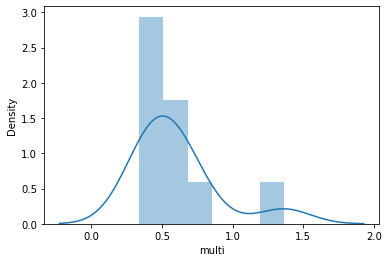

In [25]:
sns.distplot(results_norm["multi"])

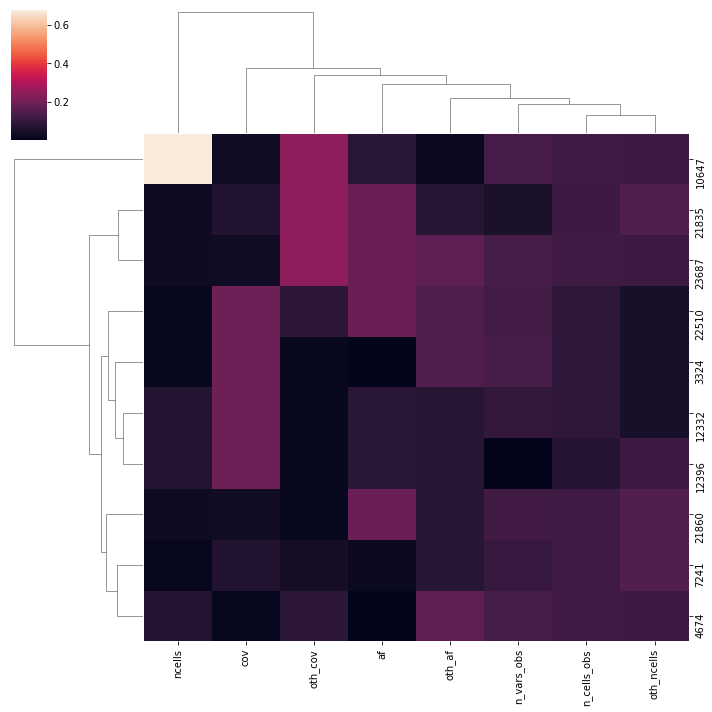

In [27]:
sns.clustermap(results_norm.drop("multi", axis=1))

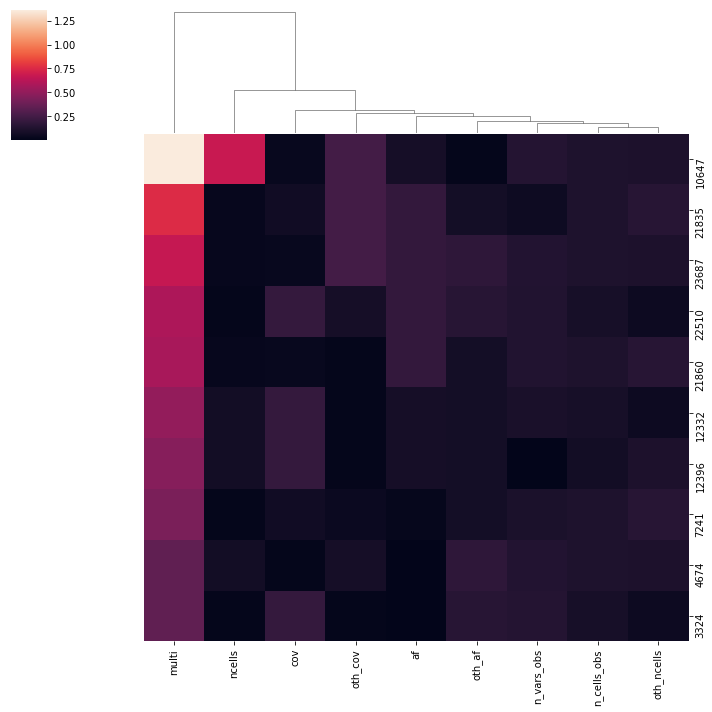

In [29]:
sns.clustermap(results_norm, row_cluster=False)

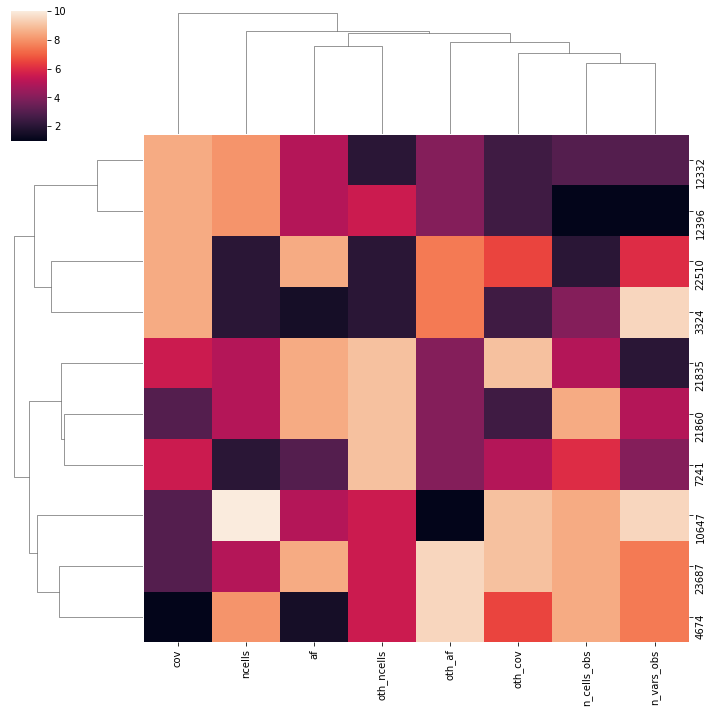

In [28]:
sns.clustermap(rank_df.drop("multi", axis=1))

In [ ]:

# seen_variants = params_results["Variants"].dropna().apply(lambda x: x.split(";"))
# params_results["Variants List"] = seen_variants
# seen_variants = set(sum(list(seen_variants.values), []))

# params_results["n_vars"] = params_results["Variants List"].apply(lambda x: len(x) if type(x) is list else 0)

# ## Save
# params_results.drop("Variants List", axis=1).to_csv(join(outdir, f"donor_{d}_thresh_results.tsv"), sep="\t", index=False)

# if to_plots:
#     plots(params_results,outdir, prefix=f"donor_{d}")



## Check subset variants

## For each thresh get the variants and other and output the list of cells

In [ ]:
for d in don_dirs: 
    curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)

    params_results = pd.read_csv(join(outdir, f"donor_{d}_thresh_results.tsv"), sep="\t")
    for thresh, curr_df in params_results.groupby(["af", "oth_af", "cov", "oth_cov"]):
        print(thresh)
        # get all variants seen here:
        curr_vars = set()
        for x in curr_df["Variants"].dropna().values:
            curr_vars = curr_vars.union(set(x.split(";")))
        
        curr_cells_vars_d = {}
        for c_var in curr_vars: #curr_af.columns:
            pos_af = curr_af[c_var]
            pos_cov = curr_cov[c_var]
            curr_cells_vars_d[c_var] = get_cells(*(thresh), pos_af, pos_cov)
        curr_f = join(cells_dir, f"don.{d}_af.{thresh[0]}_othaf.{thresh[1]}_cov.{thresh[2]}_othcov.{thresh[3]}.p")
        pickle.dump(curr_cells_vars_d, open(curr_f,'wb'))

In [ ]:
params_results.sort_values("n_vars", ascending=False)

In [ ]:
cmd = f"touch {outdir}/.complete"
!{cmd}

## For each pairwise variants check if the cells with the variant (and coverage) is over 50%, if it is remove the smaller one (create tree)